In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [9]:
curr_path = os.getcwd()
file_path = curr_path + "\\weatherww2\\SummaryofWeather.csv"

data = pd.read_csv(file_path)

STA        Date Precip  WindGustSpd    MaxTemp    MinTemp  \
0       10001    1942-7-1  1.016          NaN  25.555556  22.222222   
1       10001    1942-7-2      0          NaN  28.888889  21.666667   
2       10001    1942-7-3   2.54          NaN  26.111111  22.222222   
3       10001    1942-7-4   2.54          NaN  26.666667  22.222222   
4       10001    1942-7-5      0          NaN  26.666667  21.666667   
...       ...         ...    ...          ...        ...        ...   
119035  82506  1945-12-27      0          NaN  28.333333  18.333333   
119036  82506  1945-12-28  9.906          NaN  29.444444  18.333333   
119037  82506  1945-12-29      0          NaN  28.333333  18.333333   
119038  82506  1945-12-30      0          NaN  28.333333  18.333333   
119039  82506  1945-12-31      0          NaN  29.444444  17.222222   

         MeanTemp Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  \
0       23.888889        0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
1       25.555556        0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
2       24.444444        0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
3       24.444444        0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
4       24.444444        0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
...           ...      ...         ...  ..  ...  ..  ...  ..  ...         ...   
119035  23.333333        0         NaN  45  ... NaN  NaN NaN  NaN         NaN   
119036  23.888889        0           1  45  ... NaN  NaN NaN  NaN           1   
119037  23.333333        0           1  45  ... NaN  NaN NaN  NaN           1   
119038  23.333333        0         NaN  45  ... NaN  NaN NaN  NaN         NaN   
119039  23.333333        0         NaN  45  ... NaN  NaN NaN  NaN         NaN   

        SD3  RHX  RHN RVG  WTE  
0       NaN  NaN  NaN NaN  NaN  
1       NaN  NaN  NaN NaN  NaN  
2       NaN  NaN  NaN NaN  NaN  
3       NaN  NaN  NaN NaN  NaN  
4       NaN  NaN  NaN NaN  NaN  
...     ...  ...  ...  ..  ...  
119035  NaN  NaN  NaN NaN  NaN  
119036  NaN  NaN  NaN NaN  NaN  
119037  NaN  NaN  NaN NaN  NaN  
119038  NaN  NaN  NaN NaN  NaN  
119039  NaN  NaN  NaN NaN  NaN  

[119040 rows x 31 columns]

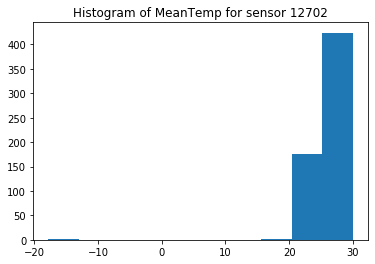

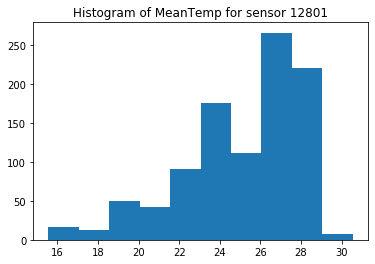

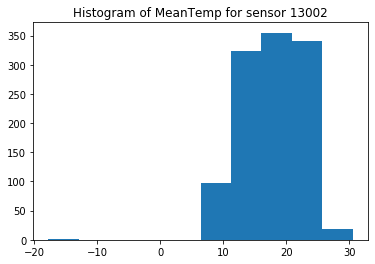

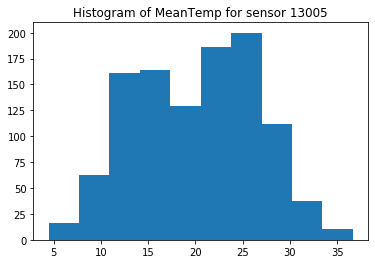

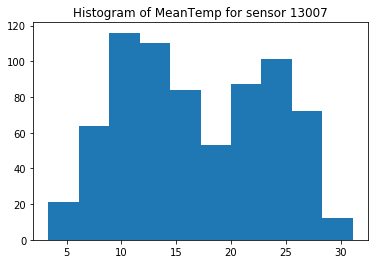

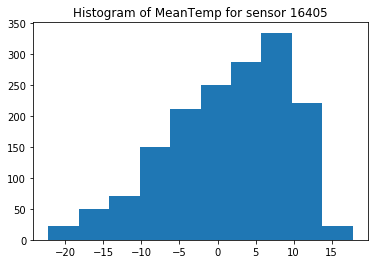

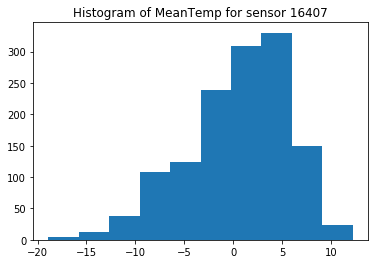

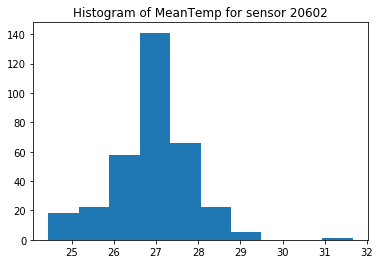

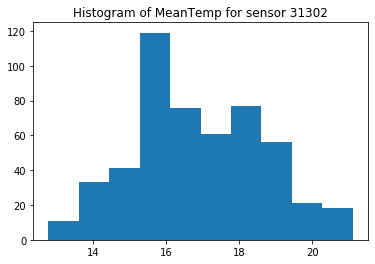

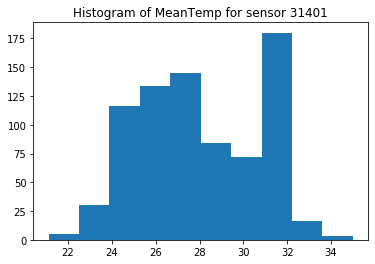

In [128]:
best_10_sensors = data.groupby('STA').any().agg("sum", axis='columns').reset_index().sort_values(by = [0], ascending = False)[:10]["STA"].tolist()
for sensor in sorted(best_10_sensors):
    data_sensor = data[data['STA'] == sensor]
    plt.hist(data_sensor["MeanTemp"])
    plt.title(f"Histogram of MeanTemp for sensor {sensor}")
    plt.show()

In [49]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

font = {'weight' : 'bold', 'size'   : 23}

plt.rc('font', **font)

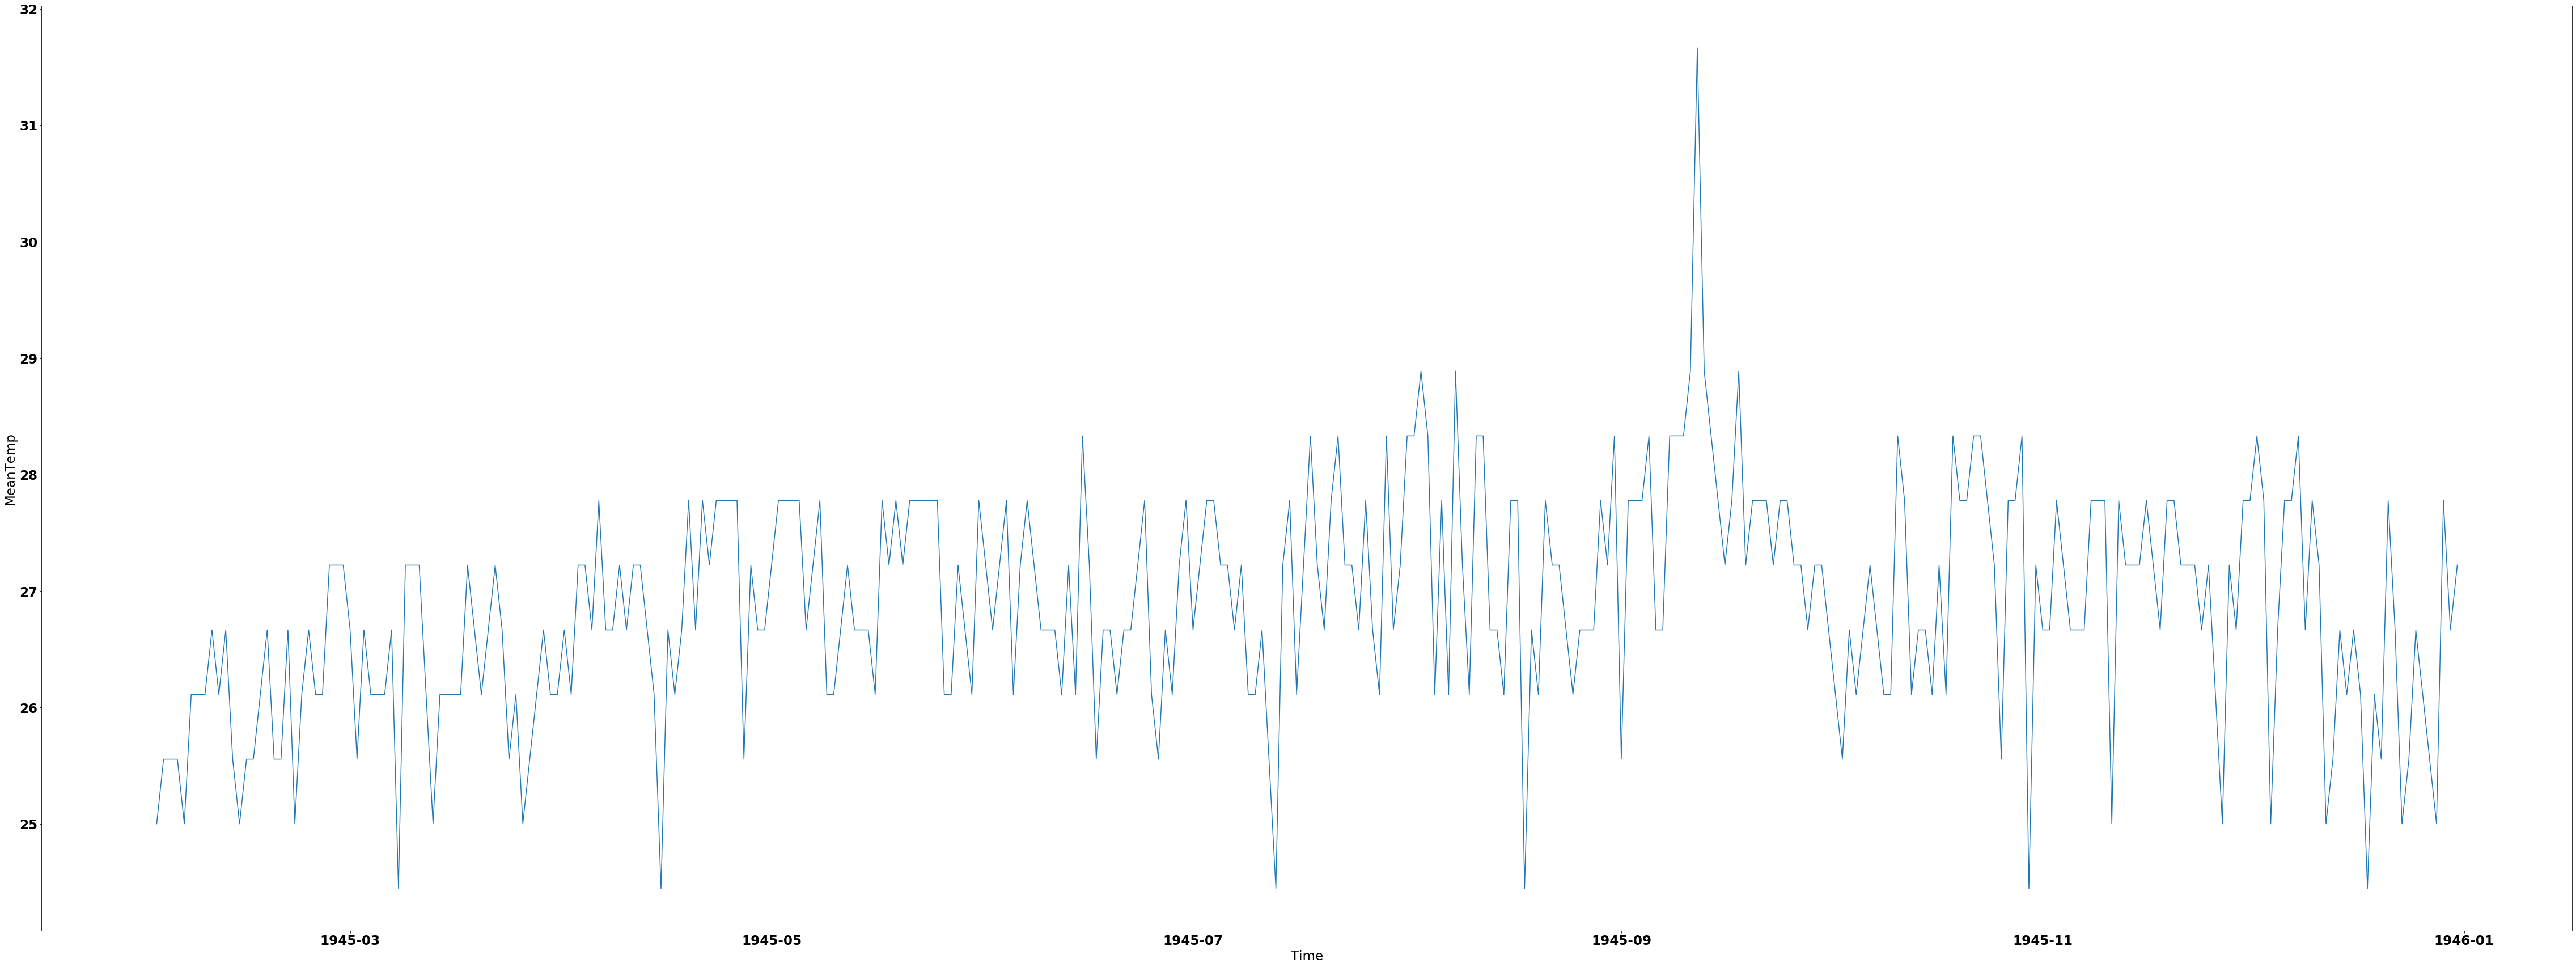

In [132]:
sensor = 20602
feature = "MeanTemp"
sensor_data = data[data['STA'] == sensor]
sensor_data.loc[:,'Date'] =  pd.to_datetime(sensor_data['Date'])

fig,ax = plt.subplots(figsize=(80,30))
ax.set_xlabel('Time')
ax.set_ylabel(feature)
ax.plot(sensor_data['Date'][-365:], sensor_data[feature][-365:])

In [125]:
# W : time window size
# T: number of samples
# D: how long in the future we want to predict

def prepare_data(values, W, D):
    T = len(values)
    X = []
    y = []
    for i in range(T-D-W):
        X.append(values[i:i+W])
        y.append(values[i+W+(D-1)])

    X = np.array(X)
    y = np.array(y)
    
    X_train = X[:-365]
    X_test = X[-365:]
    y_train = y[:-365]
    y_test =  y[-365:]
    
    return X_train, y_train, X_test, y_test
    

def make_prediction(values, W, D, reg):
    X_train, y_train, X_test, y_test = prepare_data(values, W, D)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    
    return y_test, y_pred

def value_quality(y_test, y_pred):
    r2 = r2_score(y_test,y_pred) 
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    
    return r2, mse, mae

def plot_results(y_test, y_pred):
    fig,ax = plt.subplots(figsize=(80,30))
    plt.plot(sensor_data['Date'][-365:],y_test[-365:], 'b')
    plt.plot(sensor_data['Date'][-365:],y_pred[-365:], 'r')

In [138]:
reg = LinearRegression()
d_range = [1] + list(range(30,390,30))
w_range = list(range(5,300,5))
best_ws = []

for D in d_range:
    r2_values = []
    for W in w_range:
        y_test, y_pred = make_prediction(sensor_data[feature].values, W, D, reg)
        r2, mse, mae = value_quality(y_test, y_pred)
        r2_values.append(r2)
        
    best_w = (np.argmax(r2_values)+1) 
    best_ws.append(best_w)
    
    plt.subplots()    
    plt.title(f"D={D}")
    plt.plot(w_range, r2_values)    

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

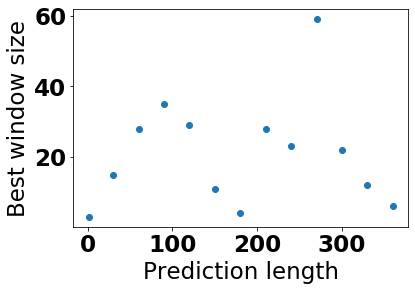

In [76]:
plt.xlabel("Prediction length")
plt.ylabel("Best window size")
plt.scatter(d_range,best_ws)

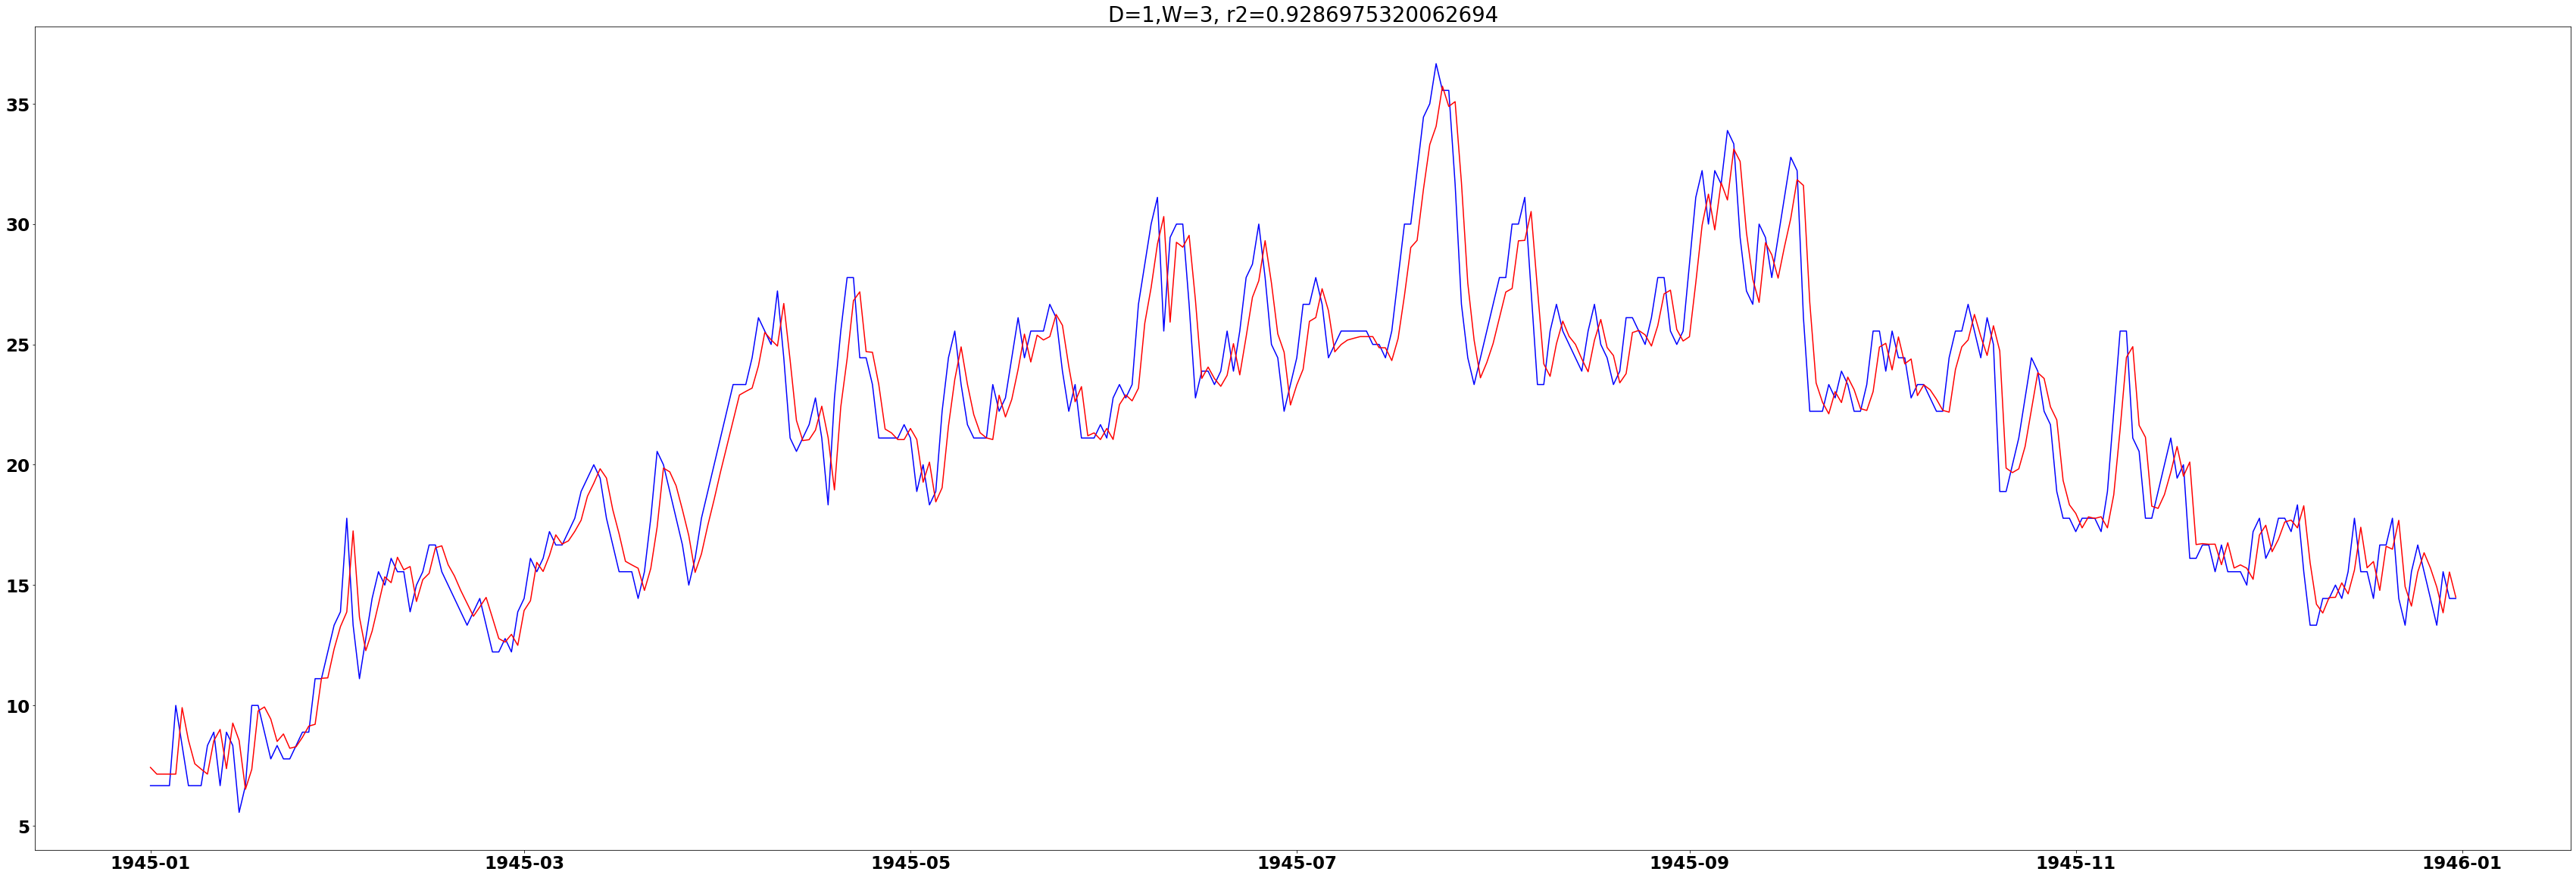

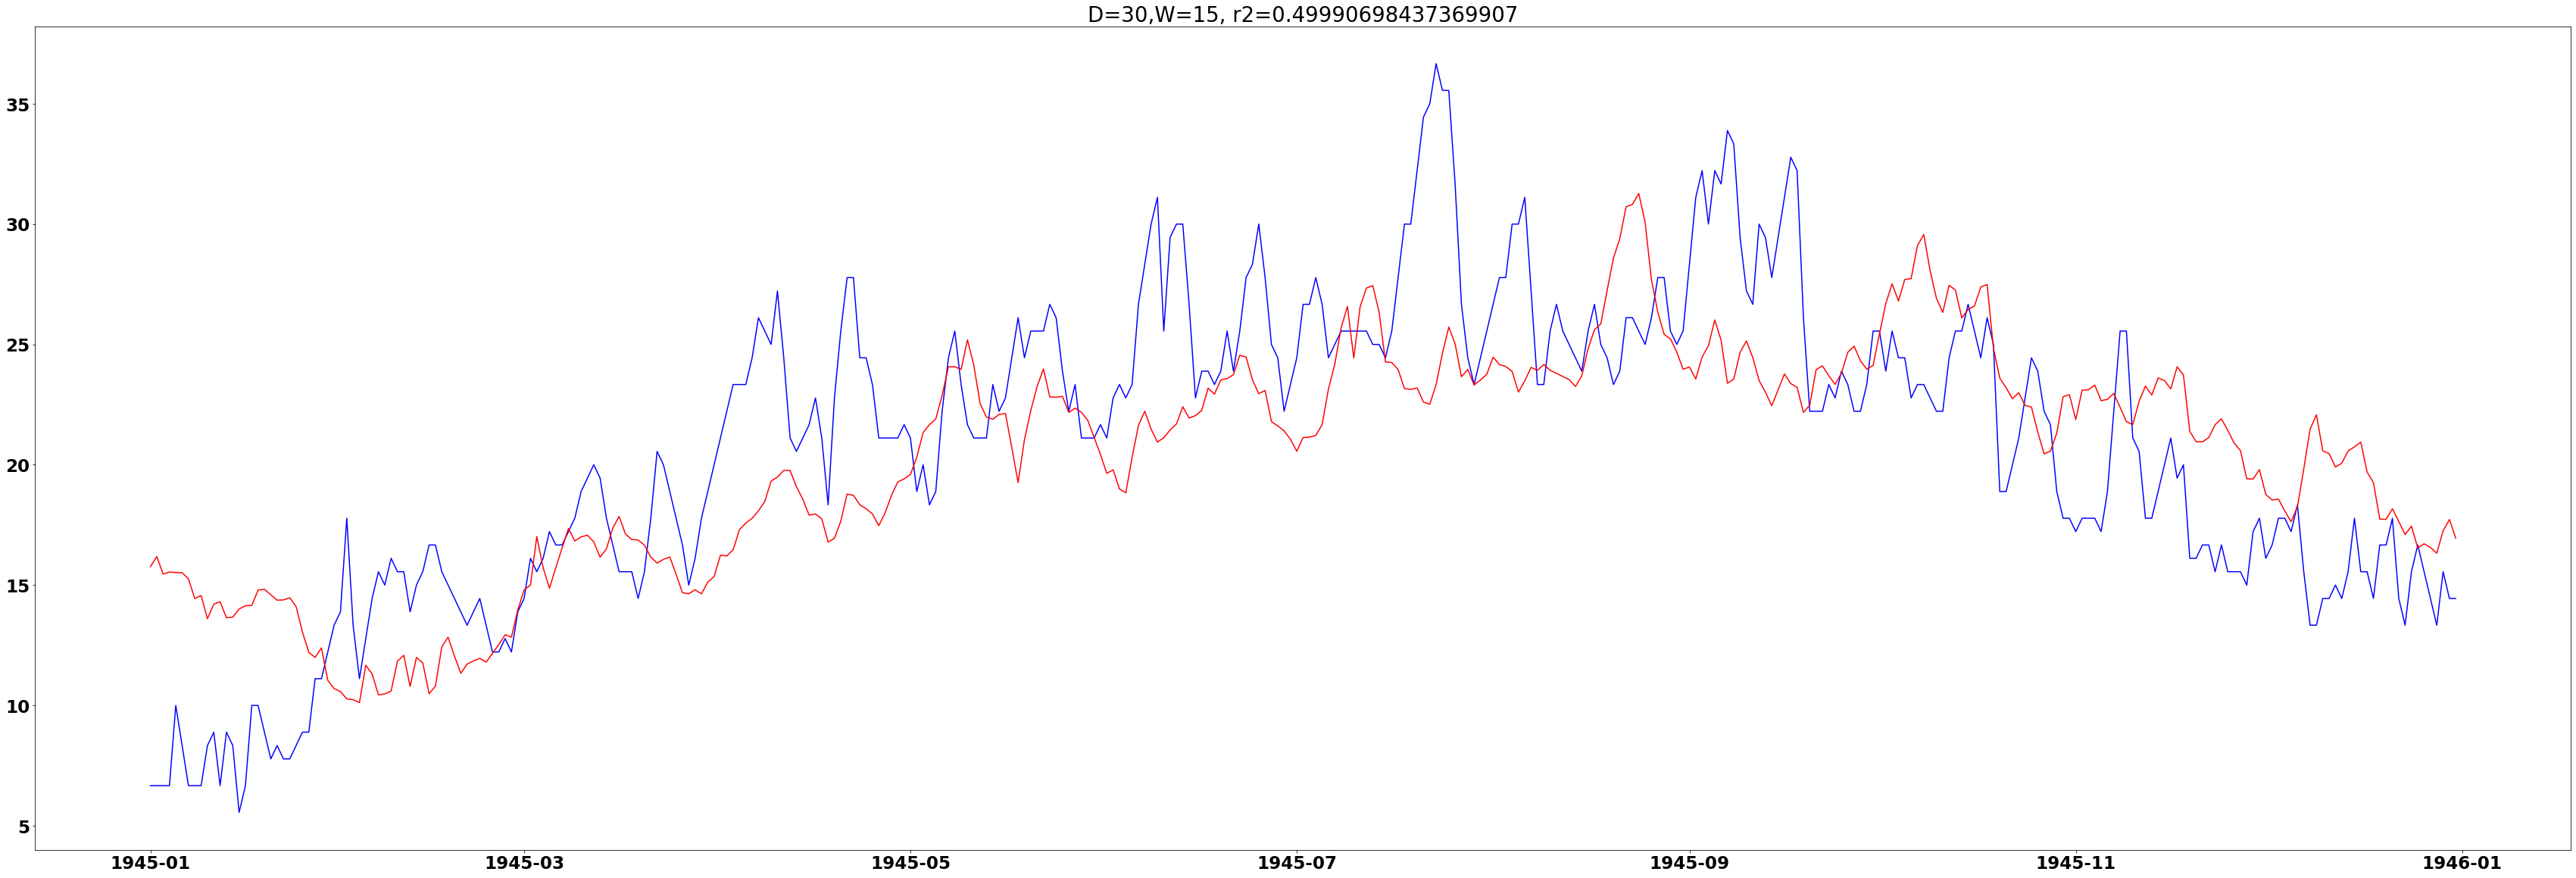

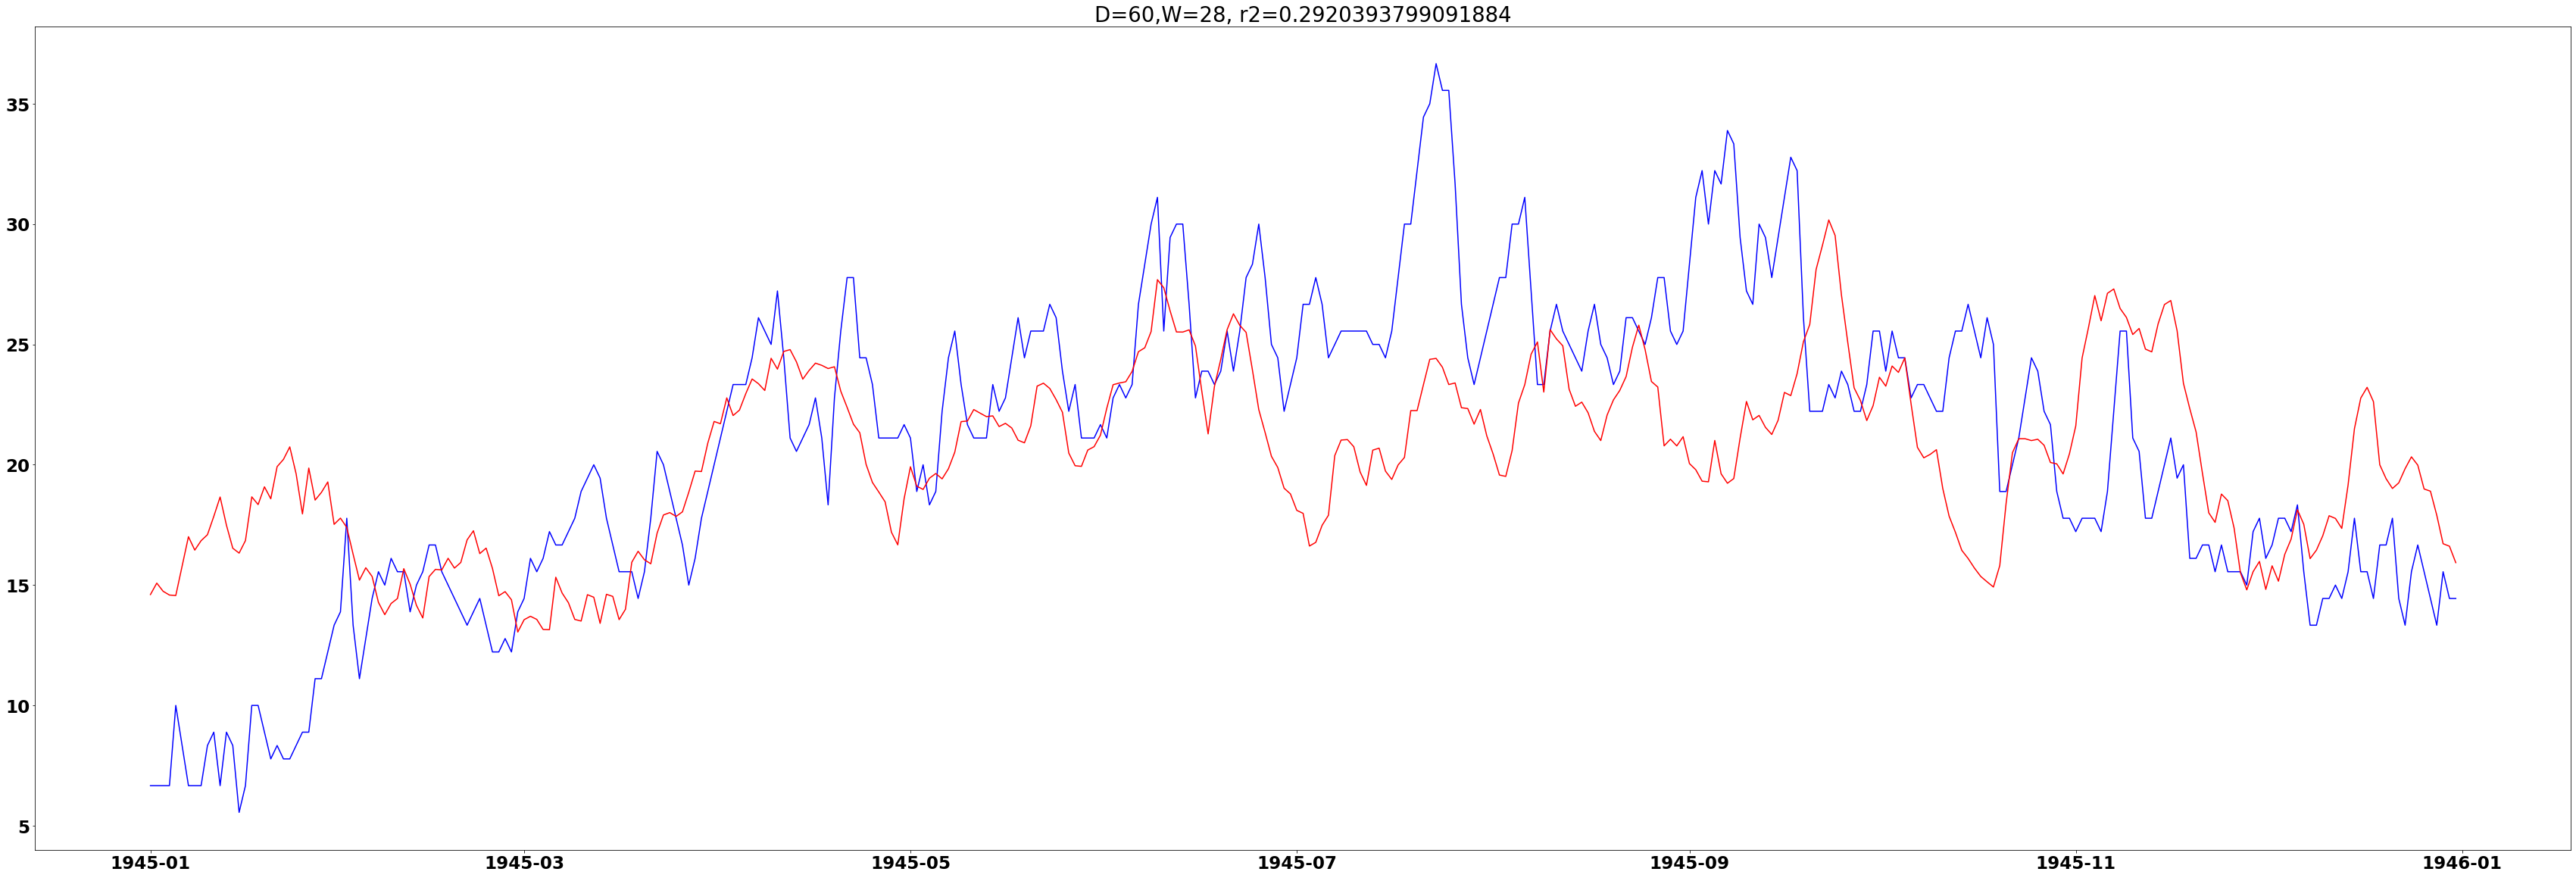

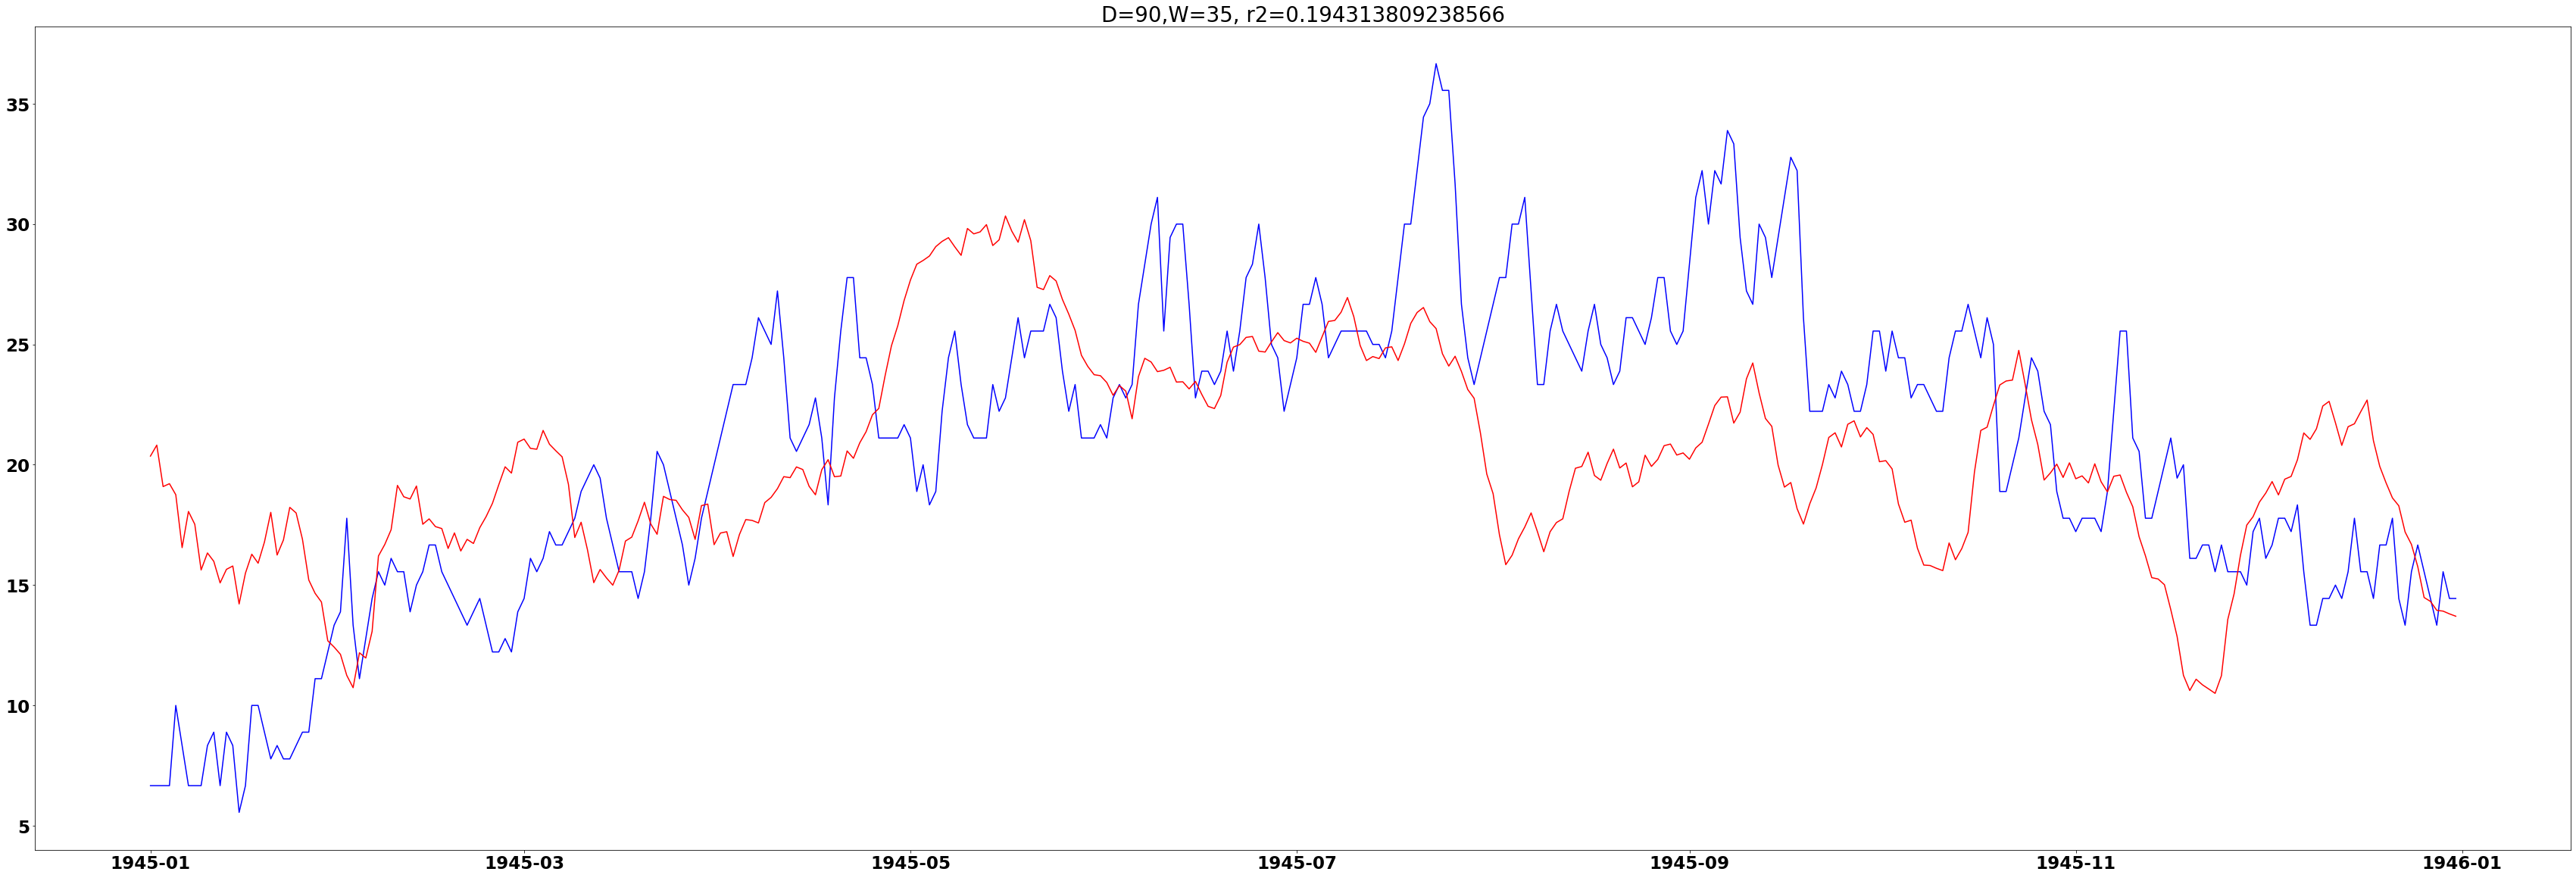

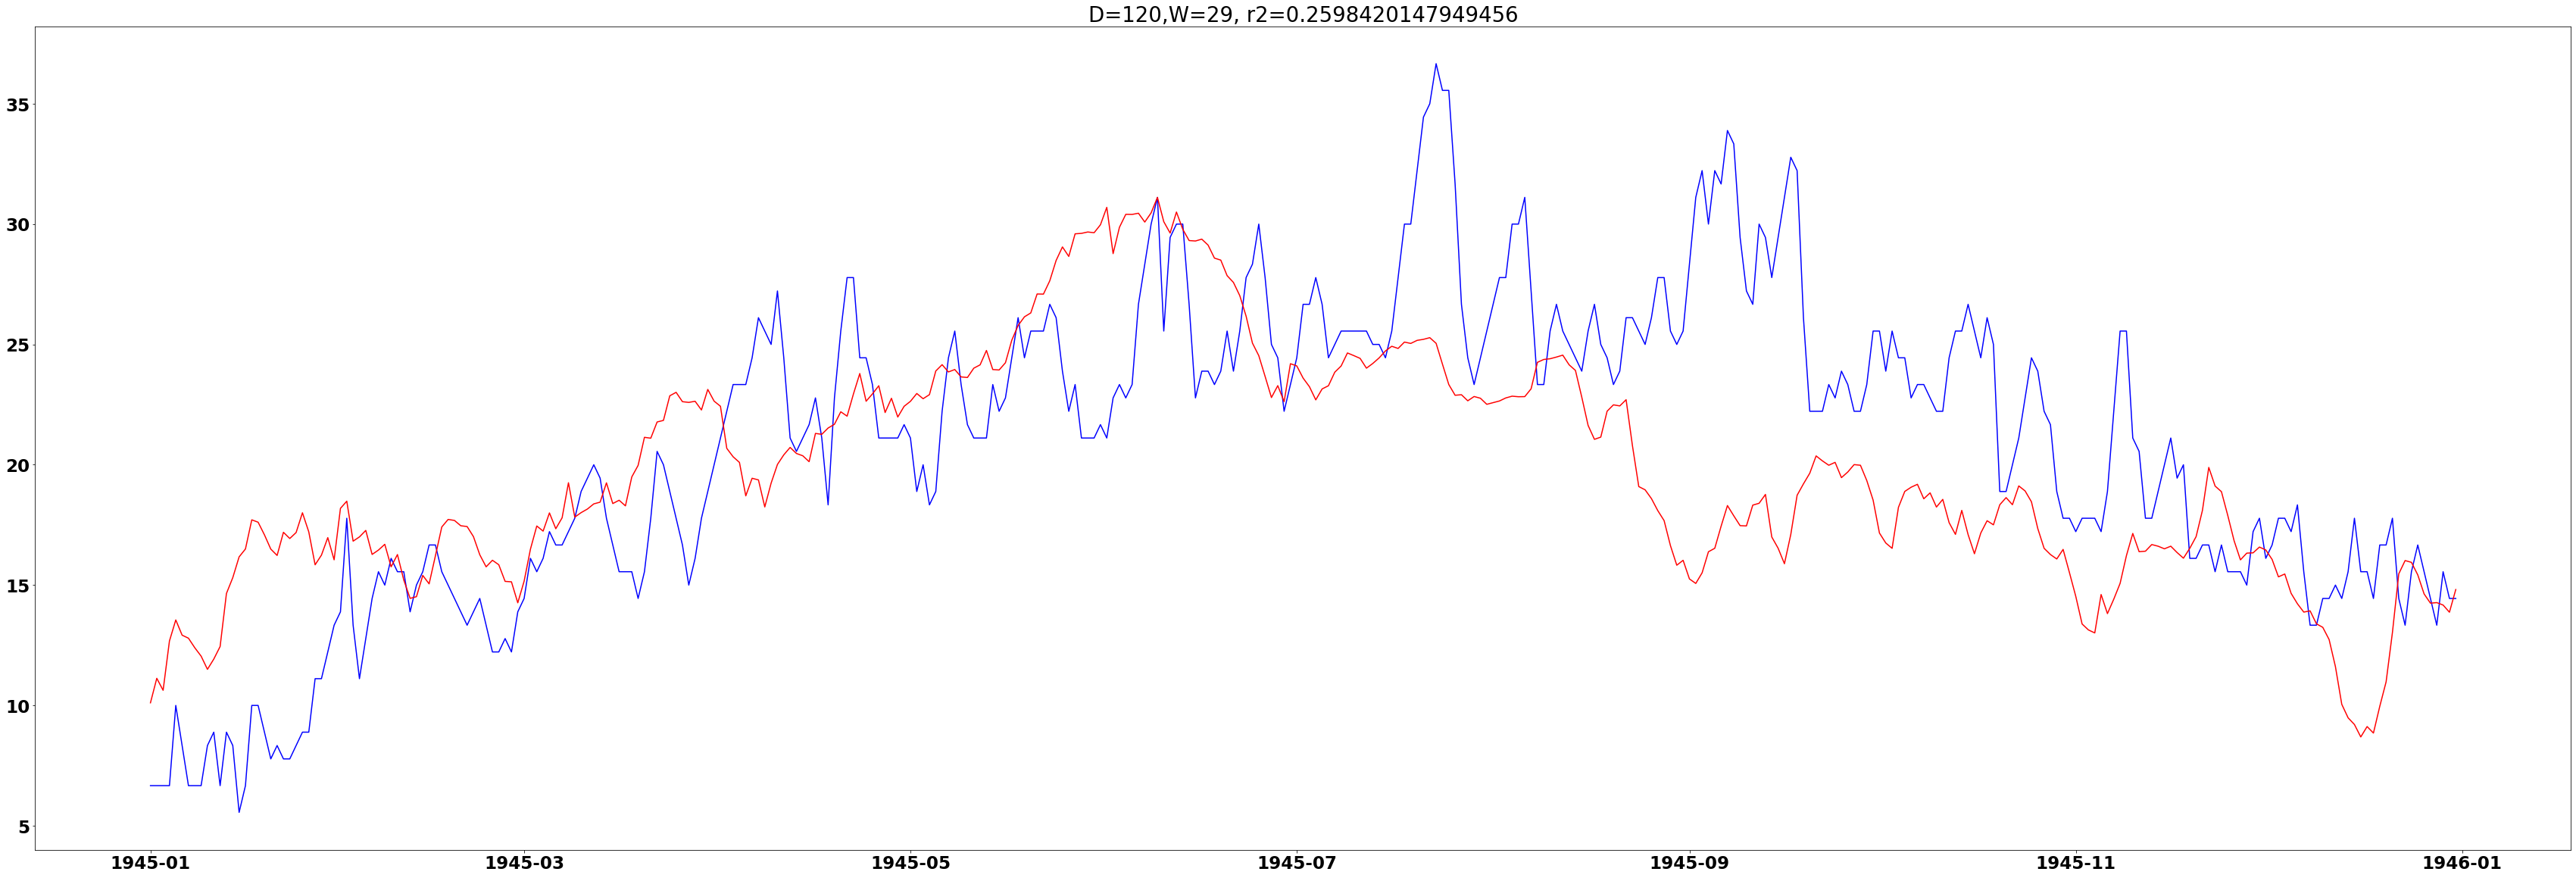

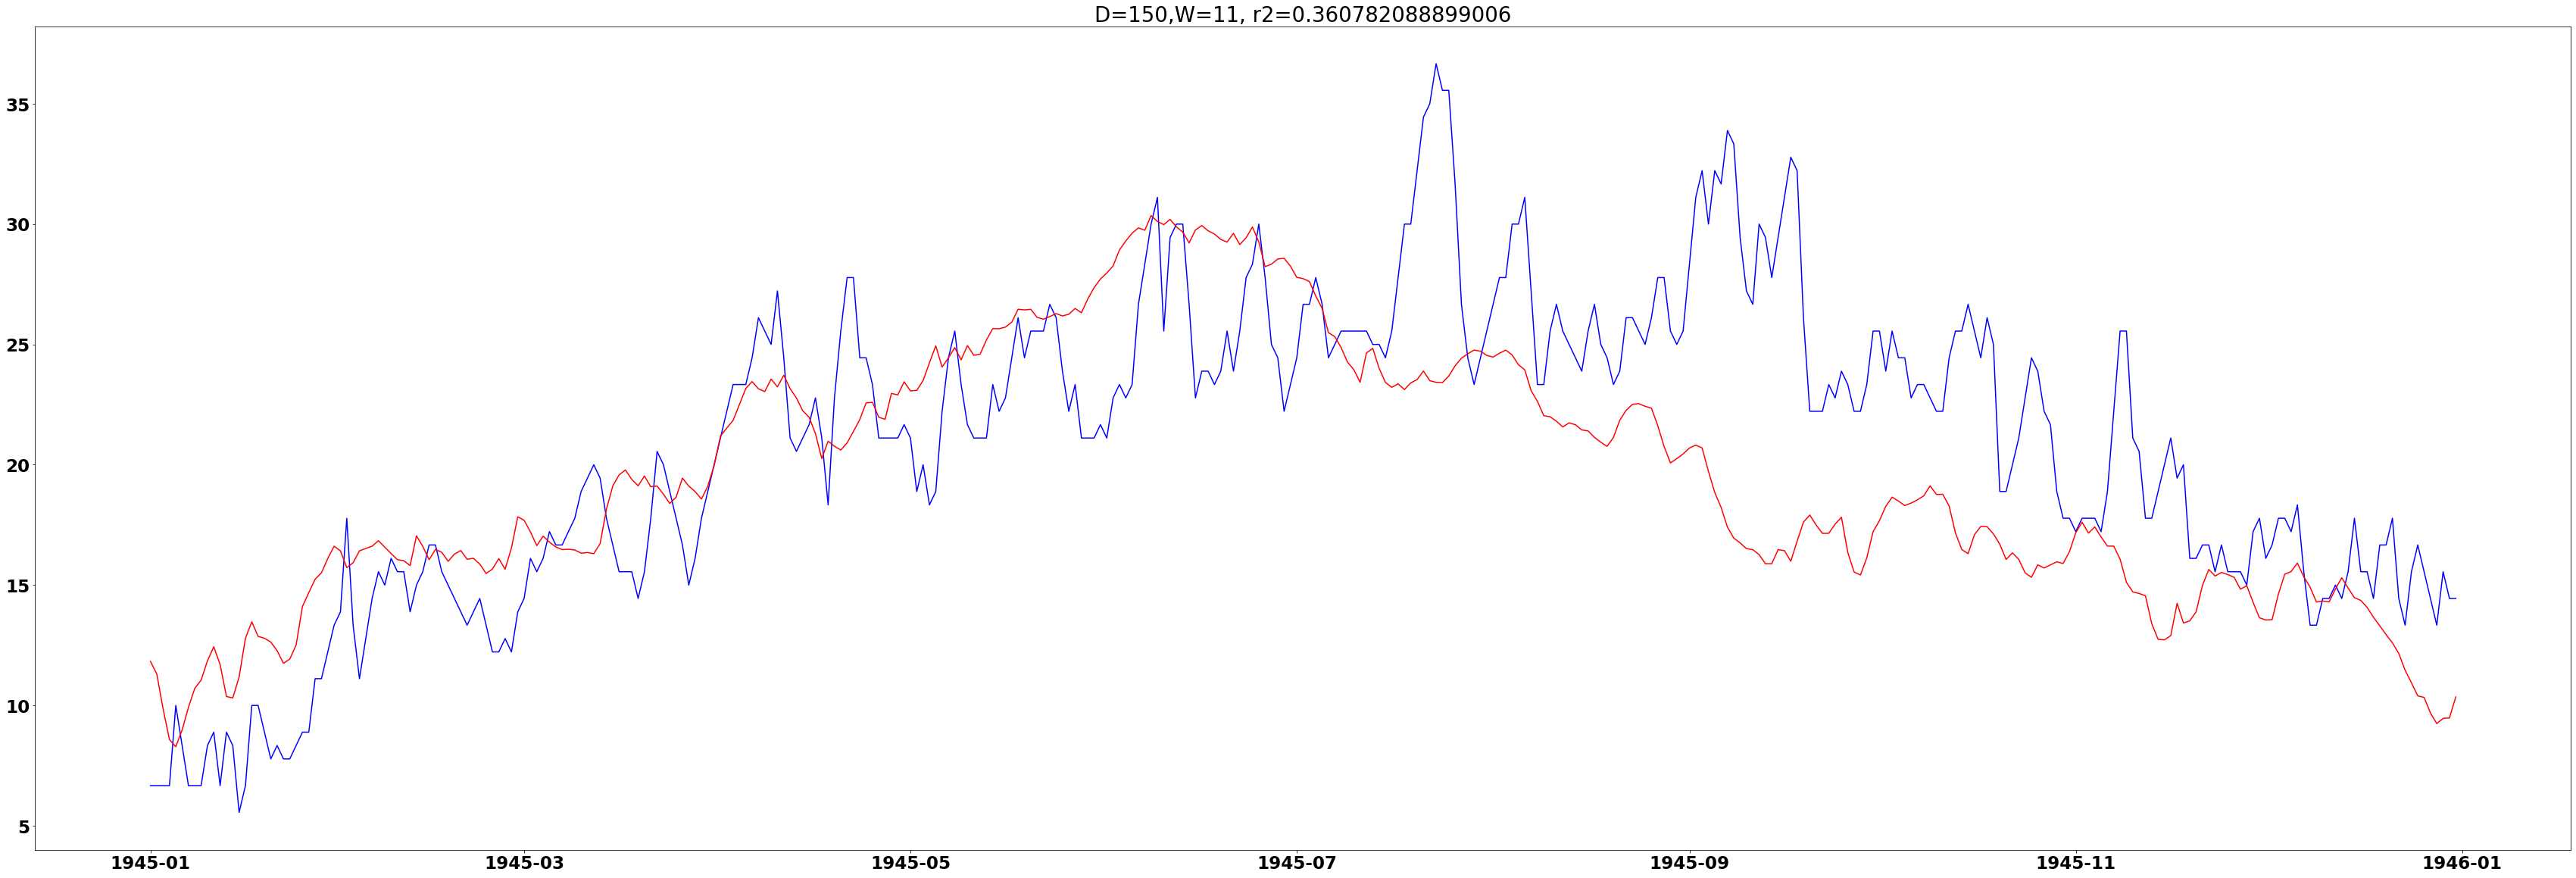

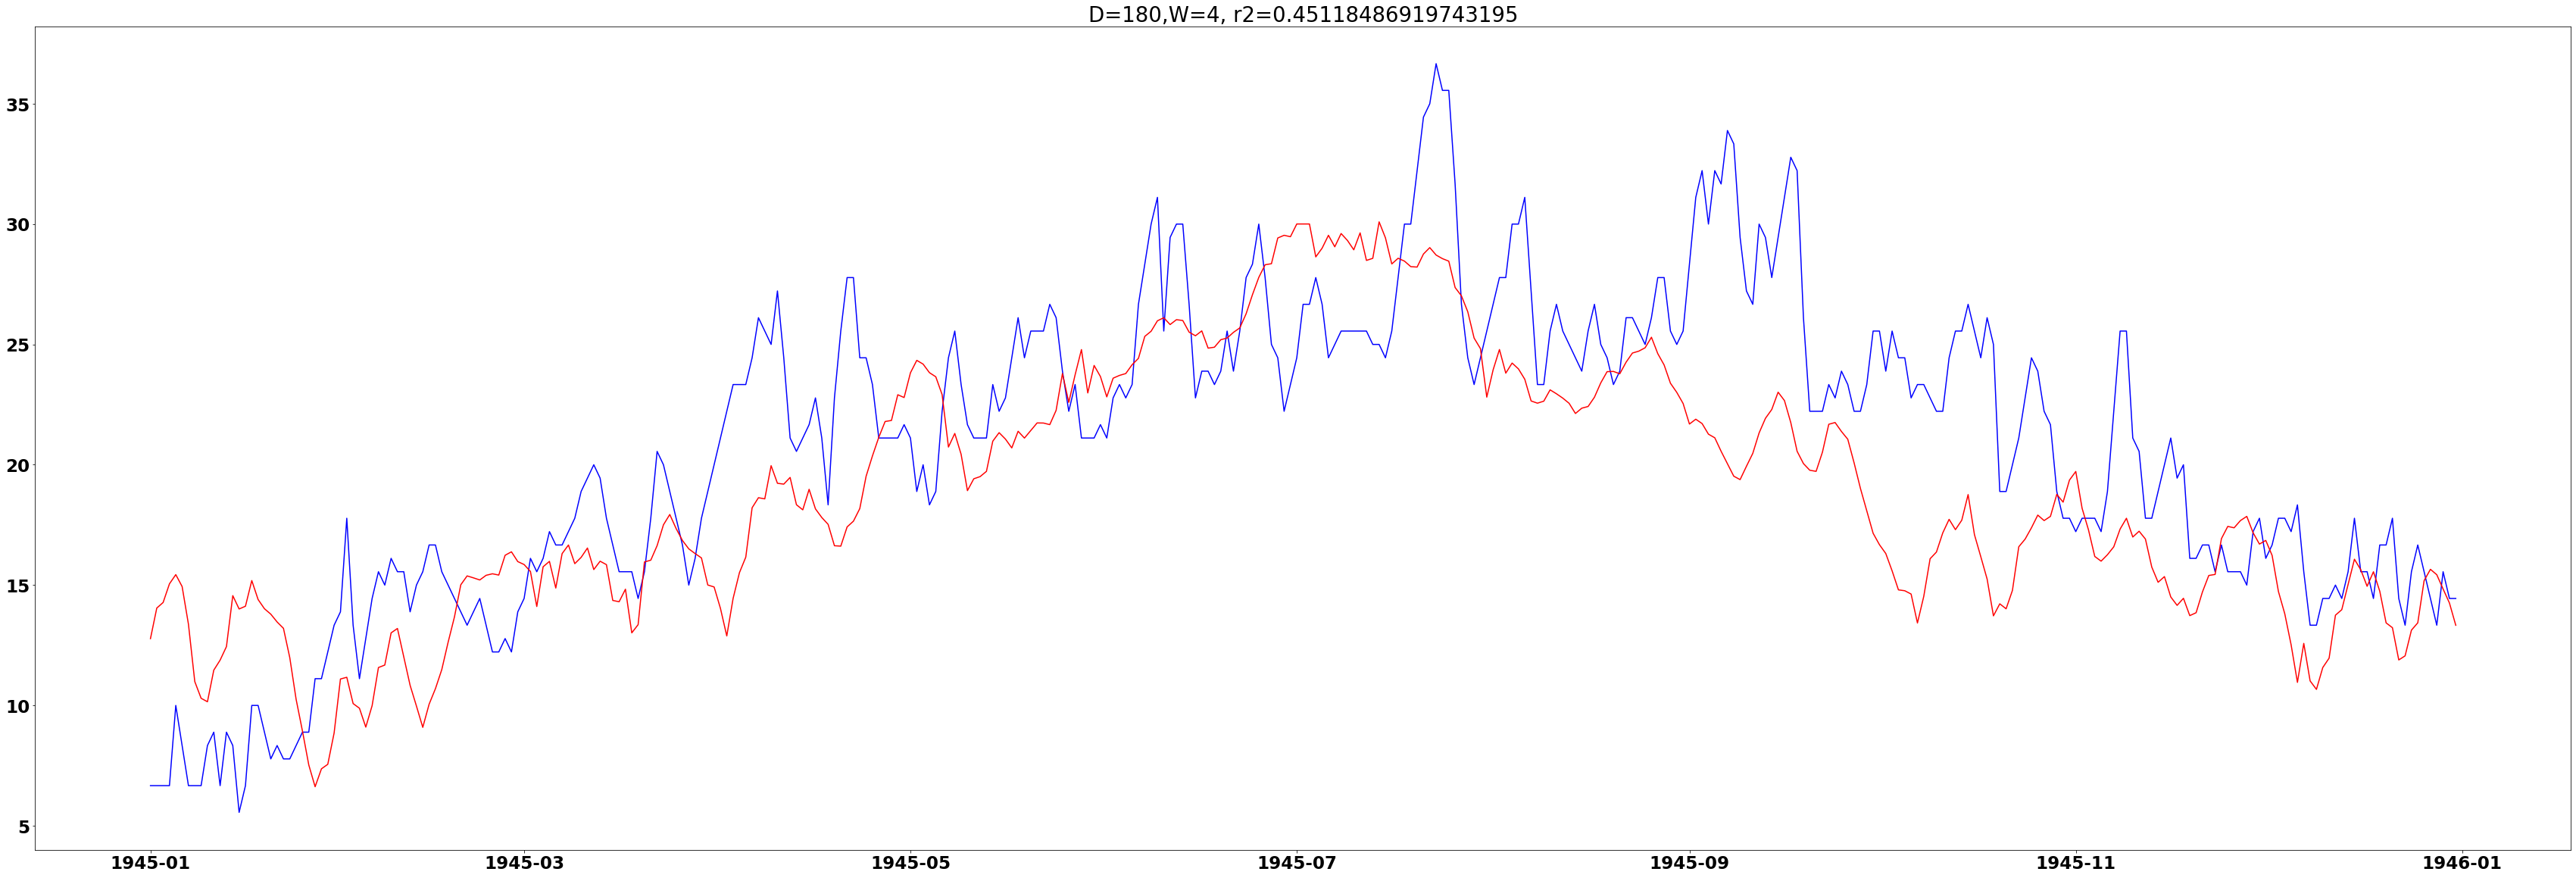

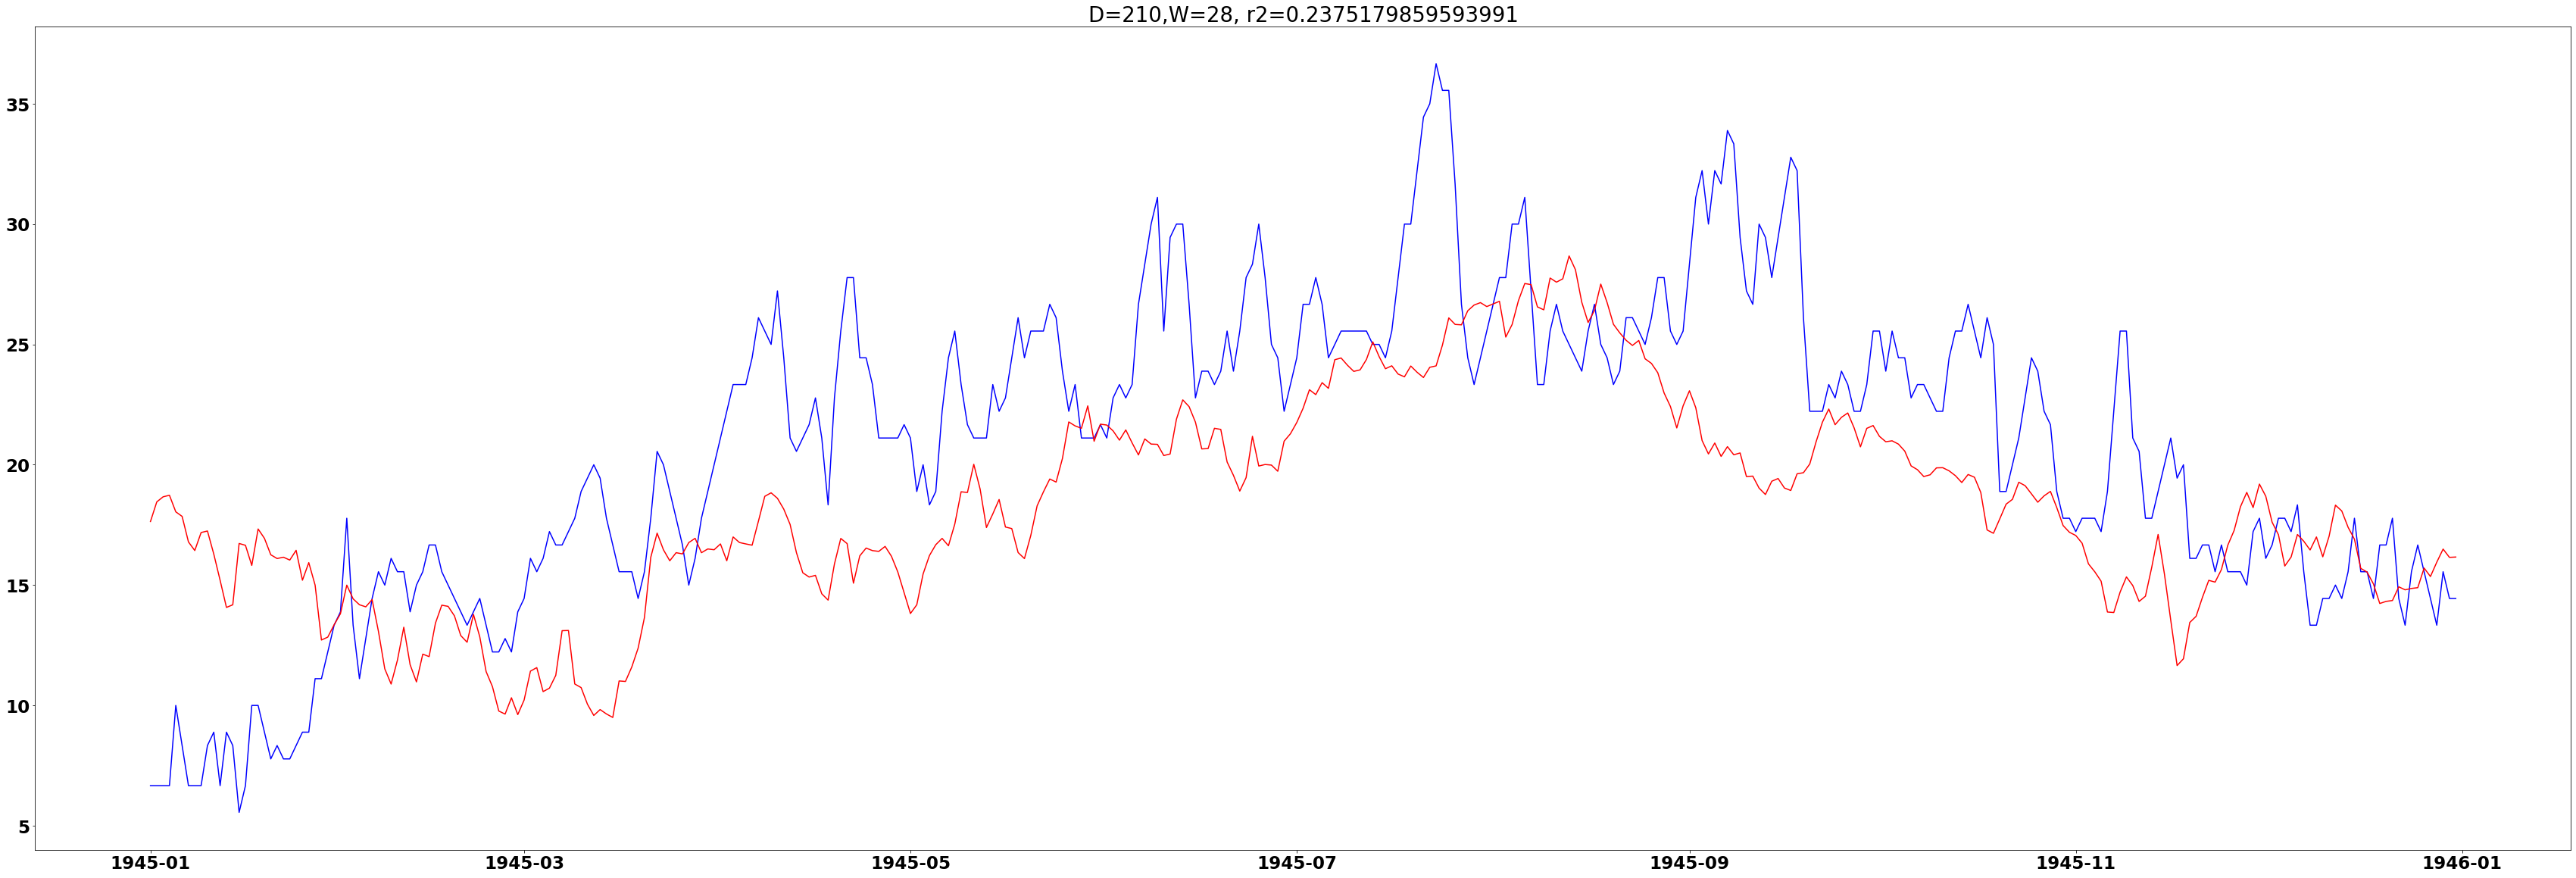

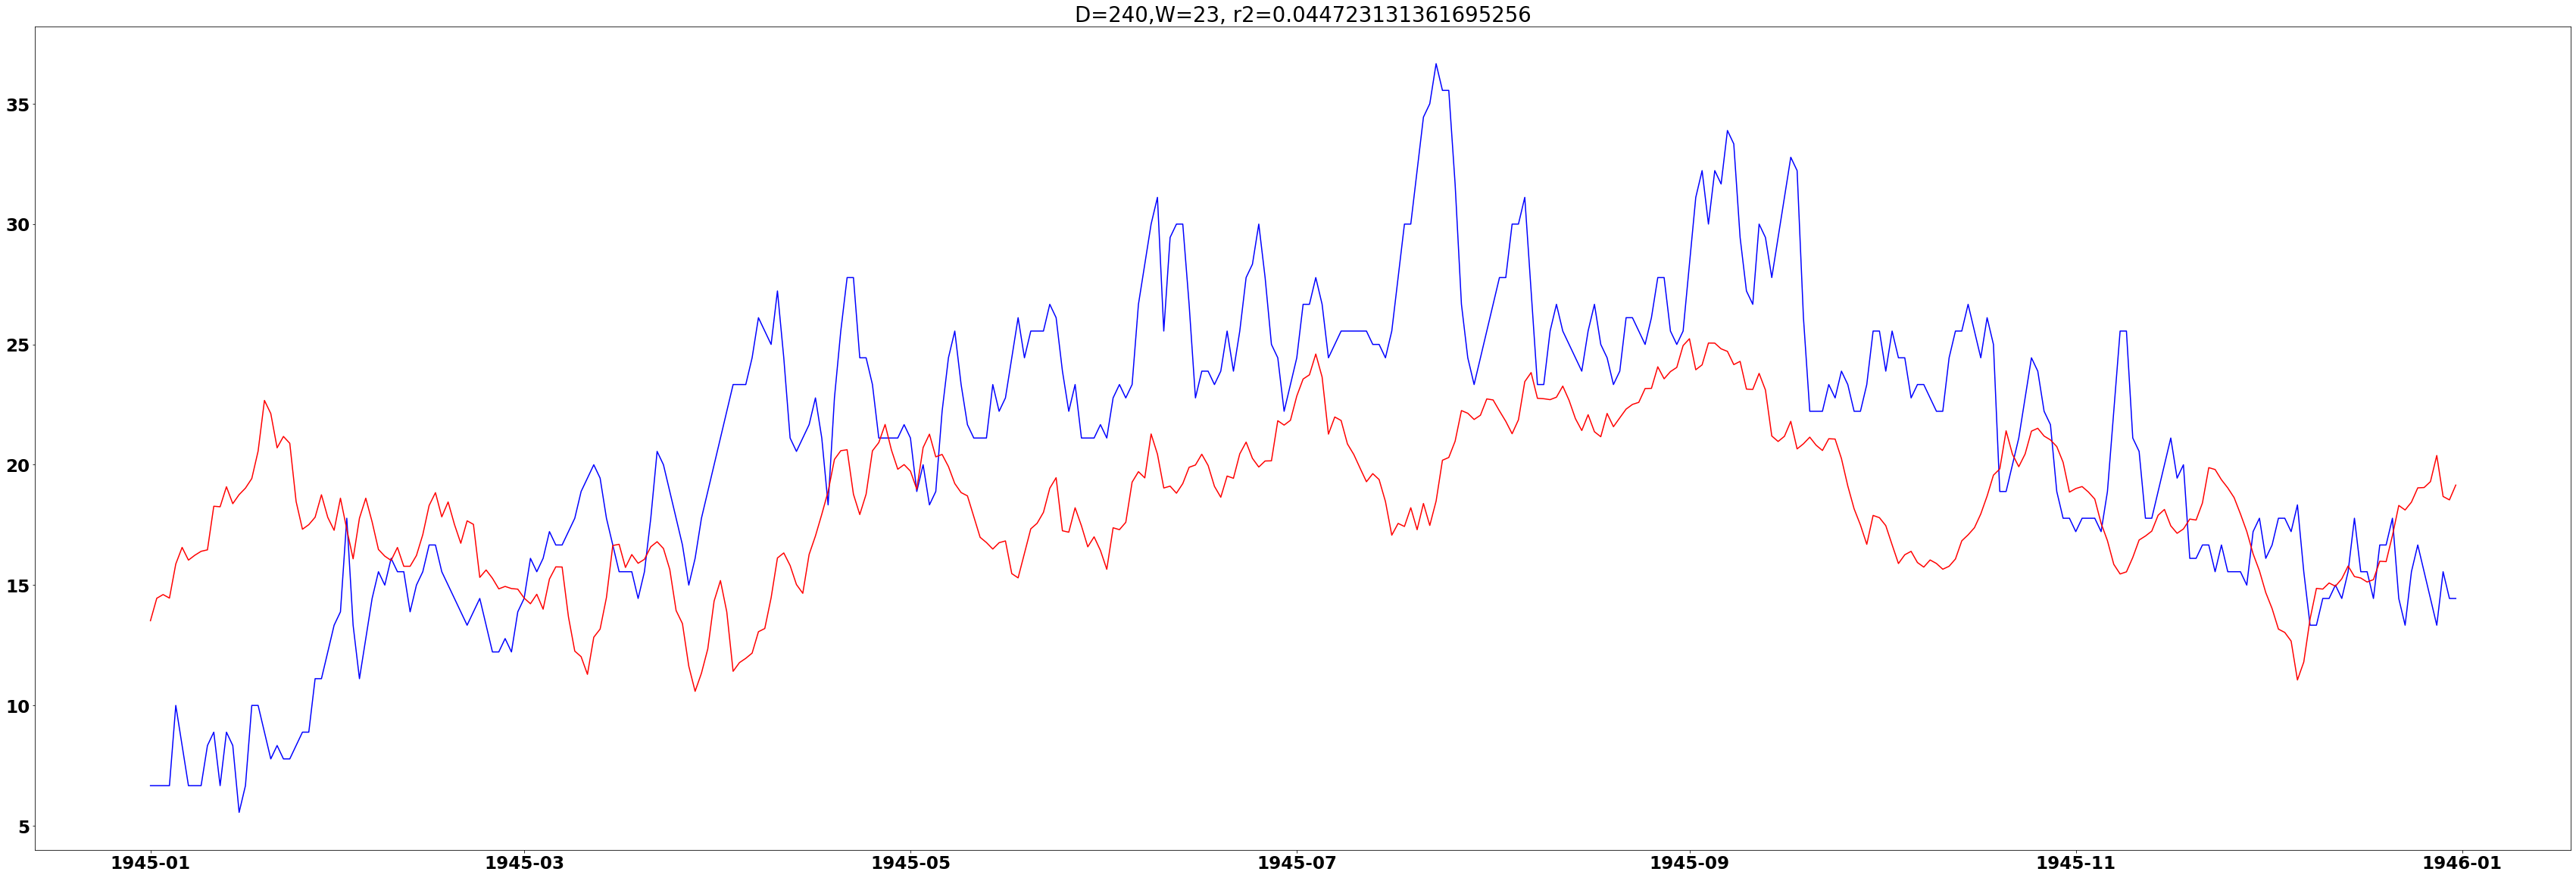

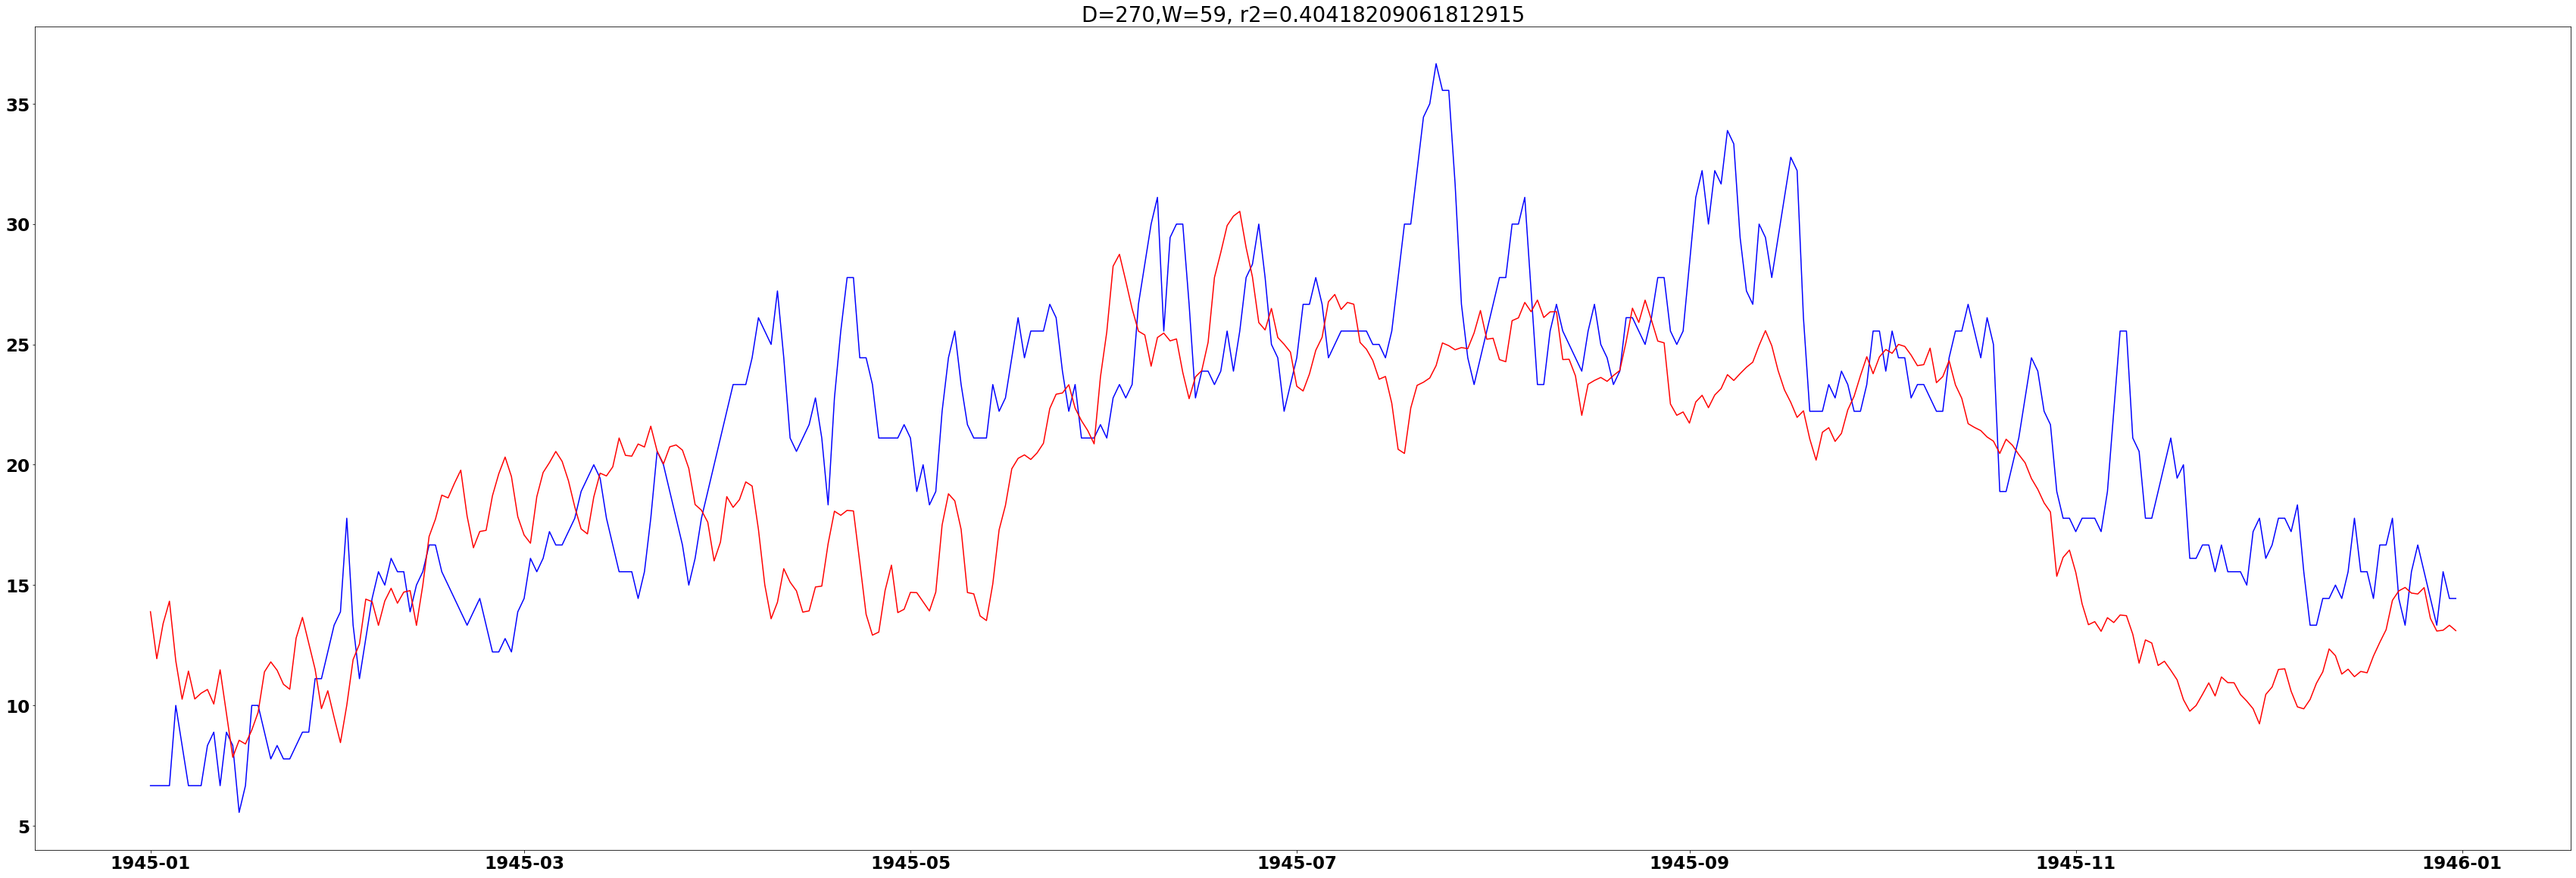

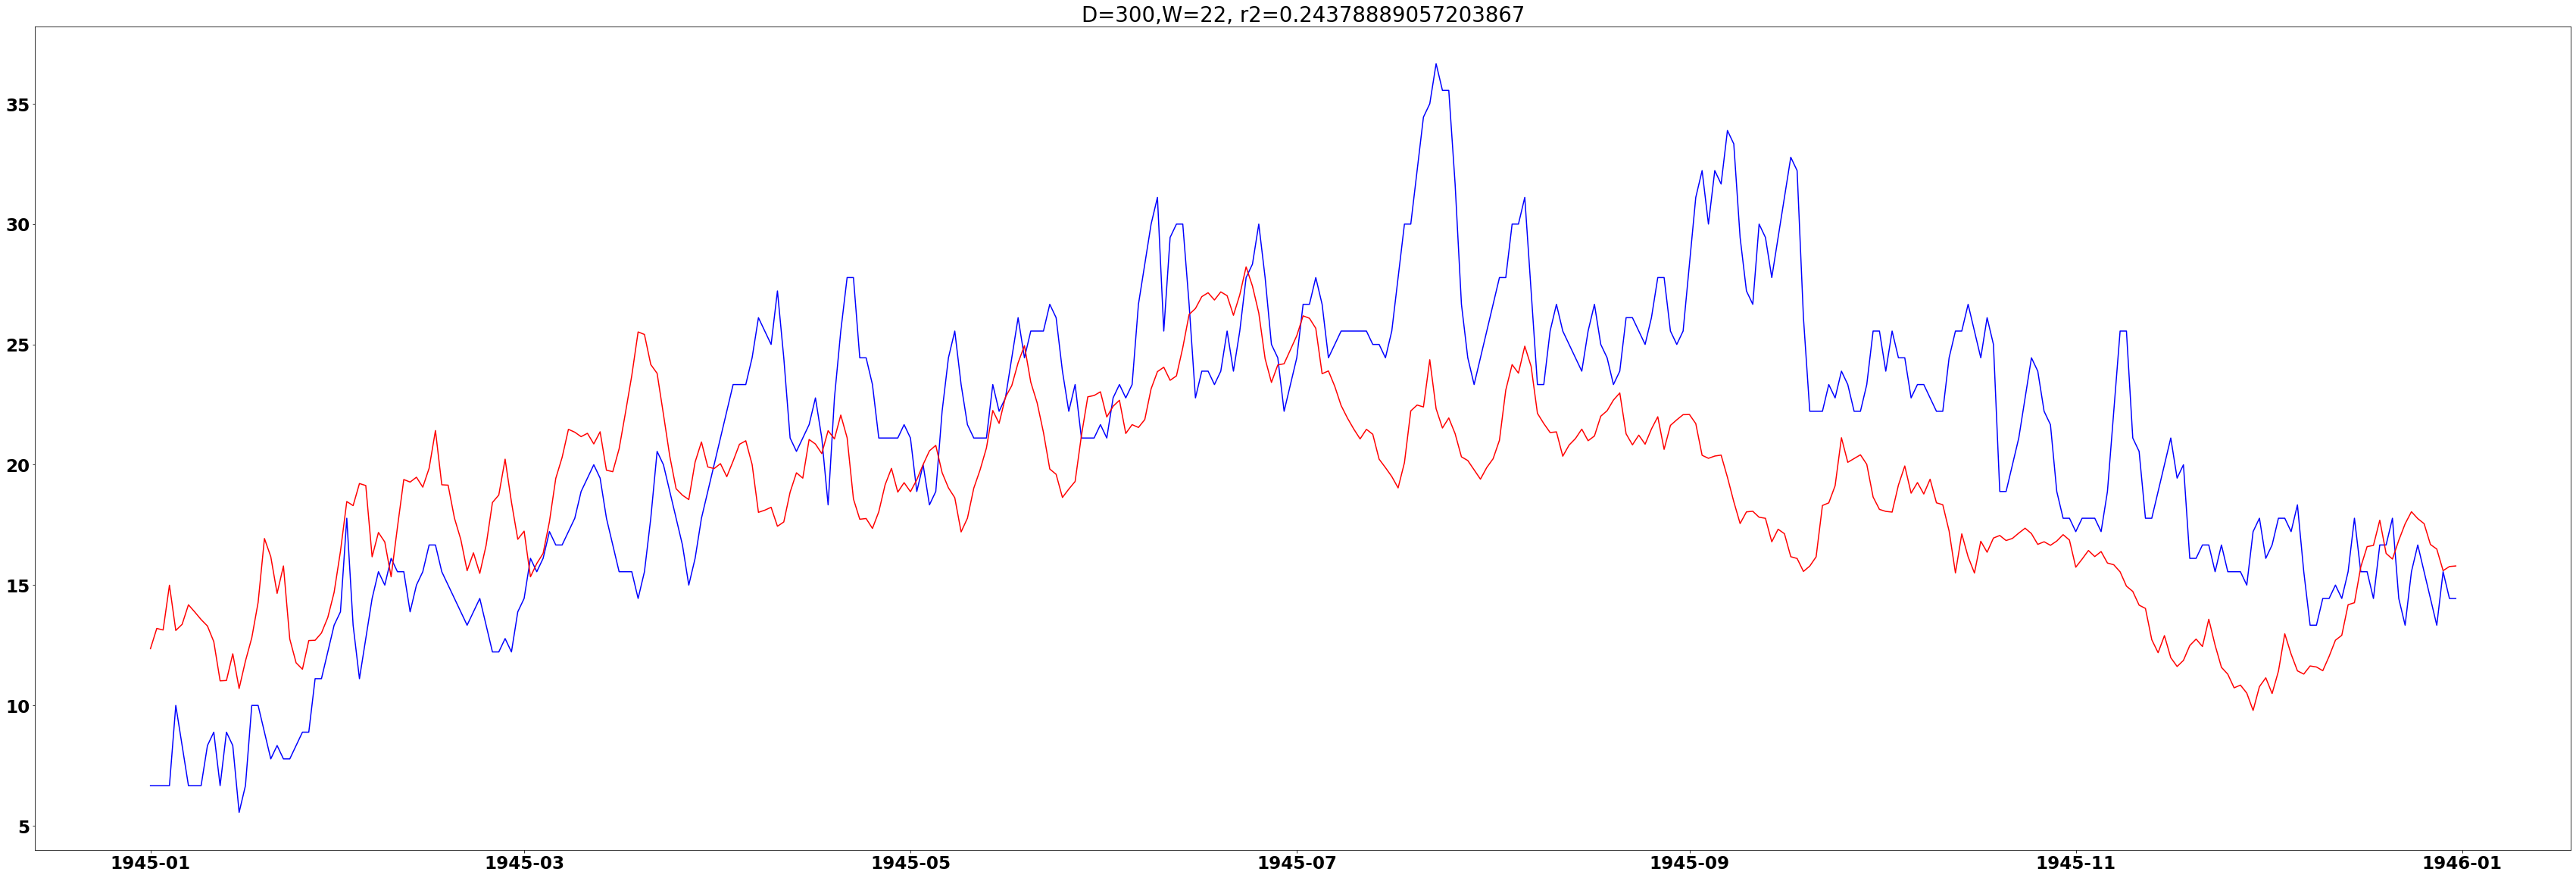

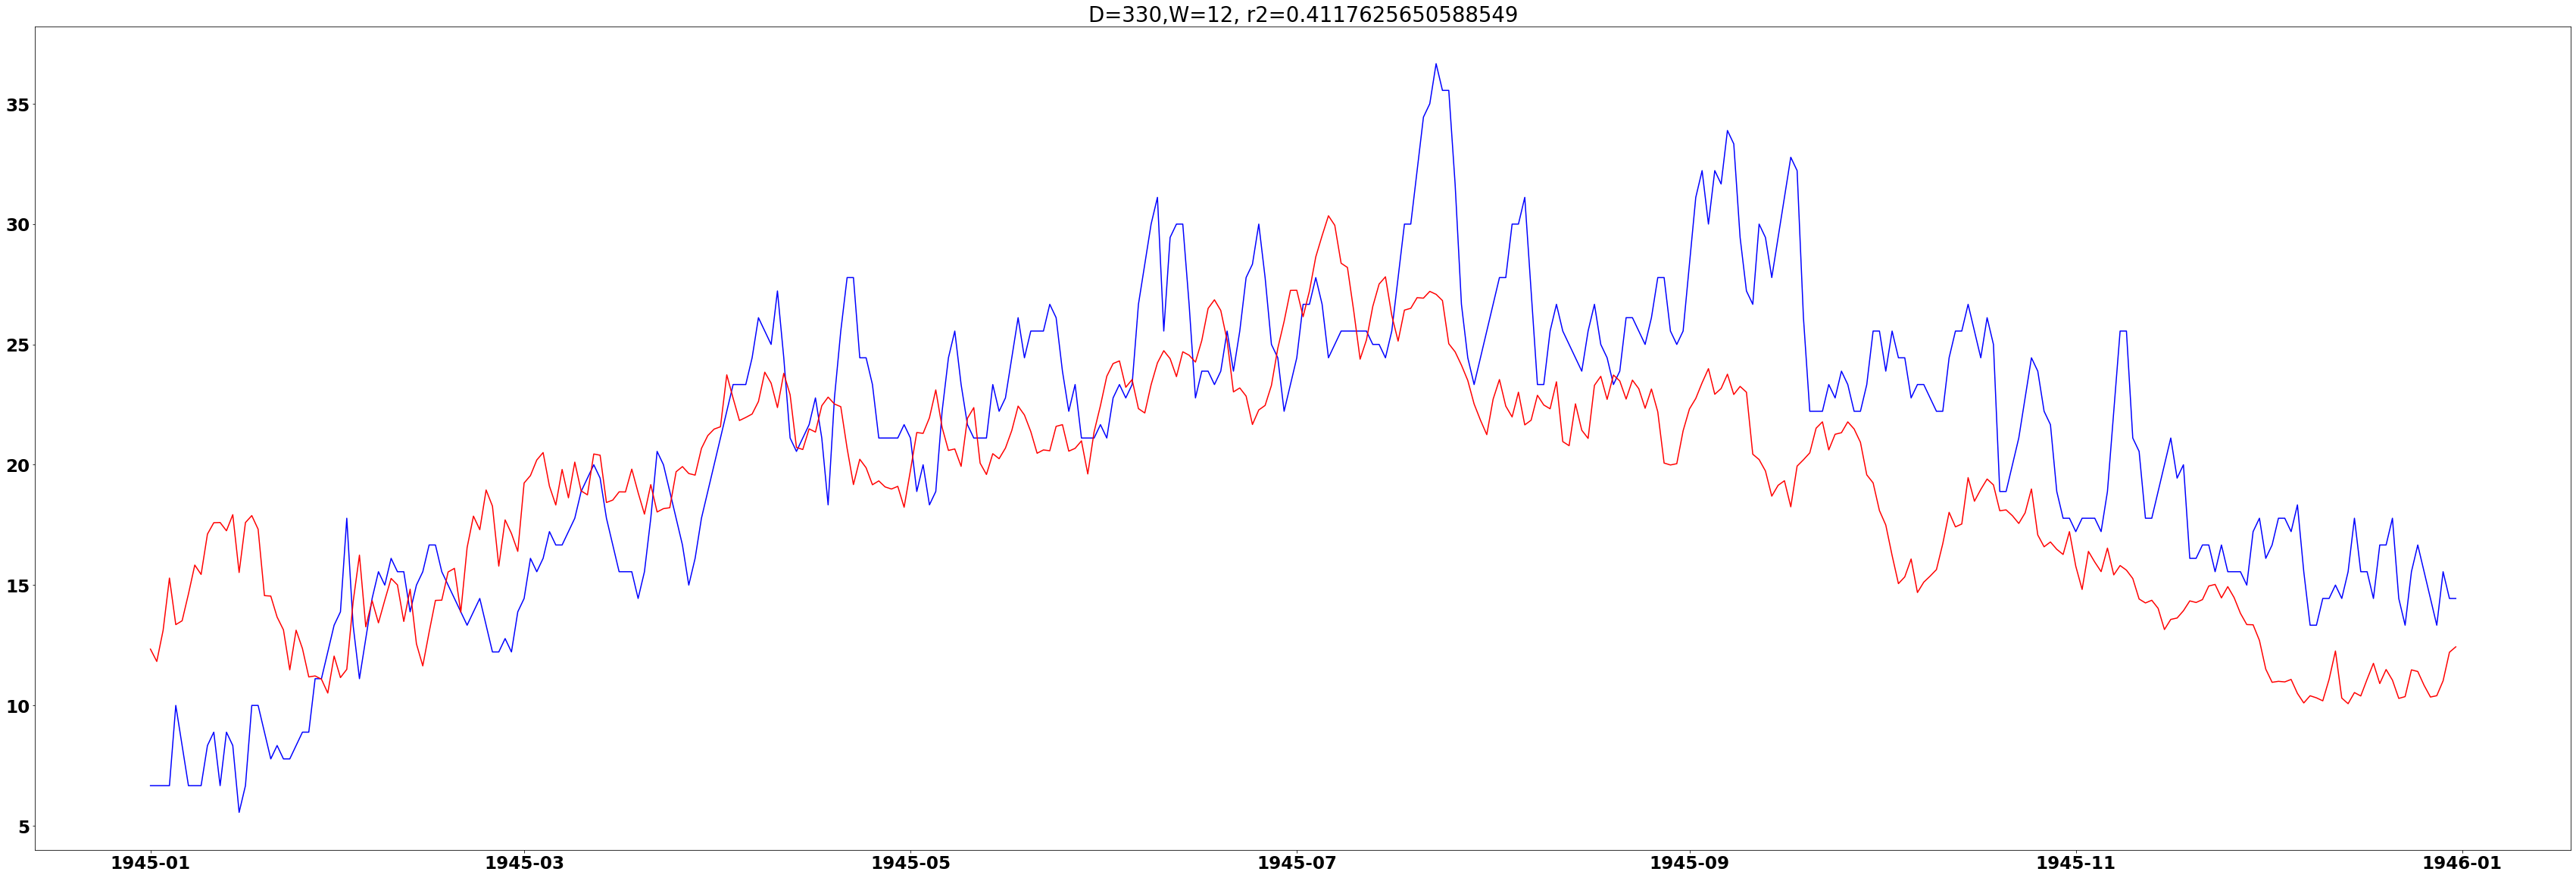

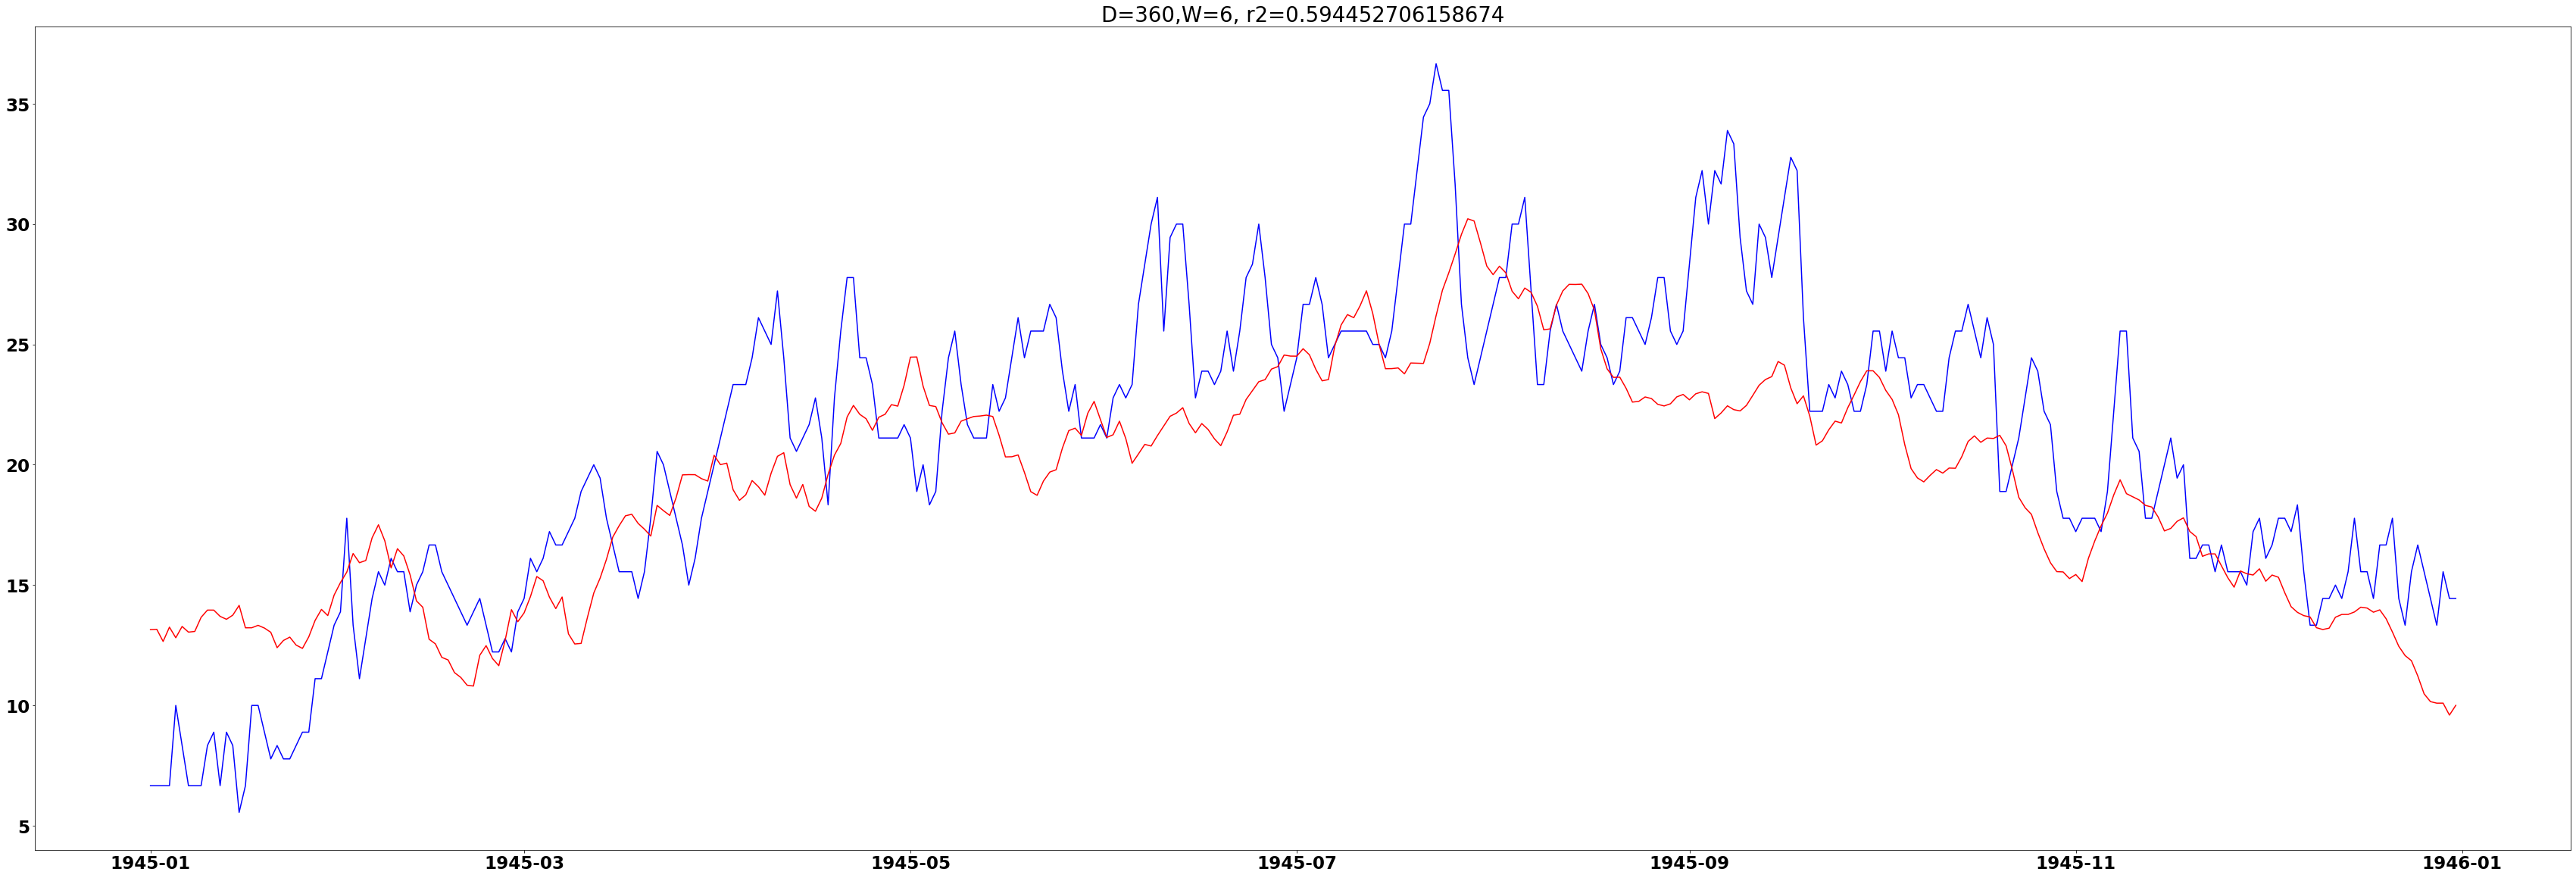

In [127]:
reg = LinearRegression()
for D,W in zip(d_range, best_ws):
    y_test, y_pred = make_prediction(sensor_data[feature].values, W, D, reg)
    r2, mse, mae = value_quality(y_test, y_pred)
    plt.subplots(figsize=(60,20))
    plt.title(f"D={D},W={W}, r2={r2}")
    plt.plot(sensor_data['Date'][-365:], y_test, c = 'b')
    plt.plot(sensor_data['Date'][-365:], y_pred, c = 'r')